# Houses Price Prediction using Stacked Regression, simple stacking technique (average base models)

The methodology used in this notebook is inspired from the one of KazAnova — Marios Michailidis. 
Source : https://medium.com/kaggle-blog/profiling-top-kagglers-kazanova-currently-2-in-the-world-f3fa9f936810.

The overall approach is presented in a concise and straightforward manner.
The feature engineering process is relatively straightforward compared to other sophisticated scripts. It includes:
- Sequentially imputing missing values in the data.
- Treating certain numerical variables as categorical by transforming them.
- Employing label encoding on categorical variables that exhibit ordered information.
- Applying the Box Cox Transformation to skewed features instead of log-transformation. This approach yielded slightly better results in both the leaderboard and cross-validation.
- Creating dummy variables for categorical features.

Next, we select numerous base models, primarily utilizing sklearn-based models, along with the sklearn API of DMLC's XGBoost and Microsoft's LightGBM. These models undergo cross-validation before being stacked.
In this notebook, 5 differents types of regression models are going to be used : 
- Lasso
- Elastic Net
- Kernel Ridge
- Gradient Boosting Regressor 
- XGBoost 
- LightGBM

Note : An important aspect is ensuring the (linear) models are robust to outliers, leading to improved results in both the leaderboard and cross-validation.
Note 2 : The optimization of the hyperparameters of some of the regression models : 1. Lasso, 2. Elastic Net and 3. Kernel Ridge have been performed thanks to another of my notebook. I used the gridsearch technique, which i applied iteratly to get the desired decimal. 
Source : https://www.kaggle.com/code/olivierraymond/hyperparameter-optimization

In [1]:
# ===============================================================================================================================
#                                                   IMPORT LIBRARIES
# ===============================================================================================================================

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

from scipy import stats
from scipy.stats import norm, skew #for some statistics

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8")) #check the files available in the directory

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


house-prices-advanced-regression-techniques



In [2]:
# ===============================================================================================================================
#                                                       READ DATA
# ===============================================================================================================================
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

# Display the first five rows of the train dataset.
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# ===============================================================================================================================
#                                               NUMBER OF SAMPLES and FEATURES.
#                                                   Drop the 'Id' Column
# ===============================================================================================================================
# Check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

# Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

# Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

# Check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 

The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


# I. DATA PROCESSING

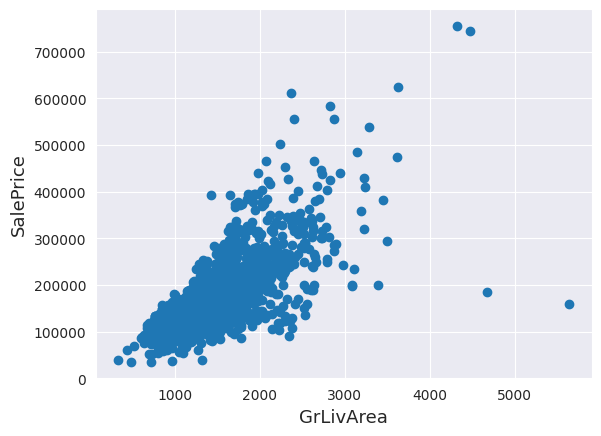

In [4]:
# ===============================================================================================================================
#                                                    I.1. REMOVE THE OUTLIERS
# ===============================================================================================================================

# Find the outliers
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

**Note:**
Two points are outliers (see down right), since the price sell of these large areas seems too lows.

--> We will delete them

/!\ There are more outliers in the training data, however, removing them all may affect negatively our models.Instead, we will make our modle robust on them. (See Modelling part)

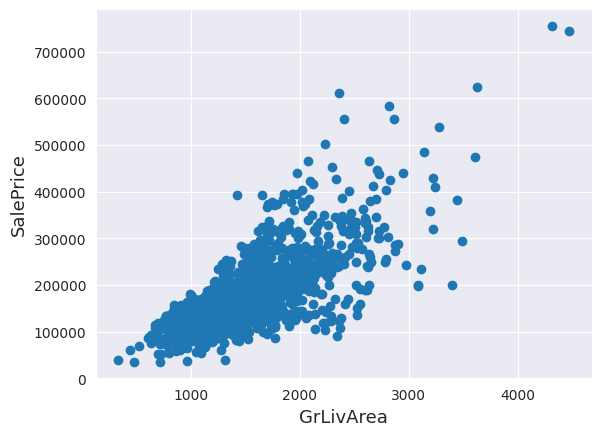

In [5]:
# Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

# Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

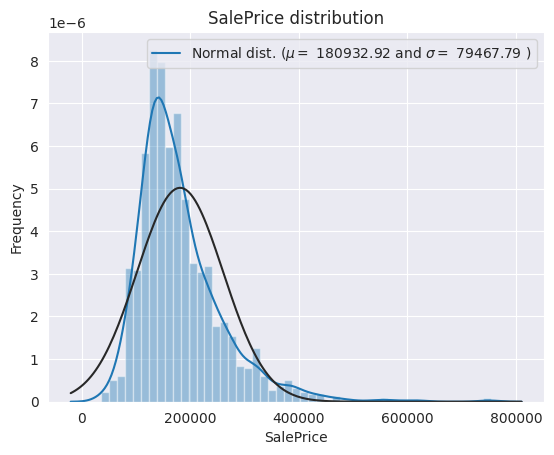

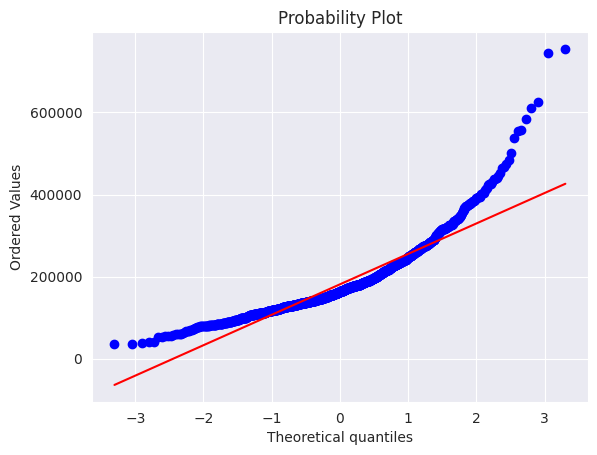

In [6]:
# ===============================================================================================================================
#                                             I.2. TARGET VARIABLE ANALYSIS ('SalePrice')
# ===============================================================================================================================
# We want to predict SalePrice variable. 
# First, let's do some analysis on this variable.

sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

**Note:**

The 'SalePrice' variable is right skewed.
We should transform this variable to make it more normally distributed. Indeed (linear) models prefers normally distributed data.

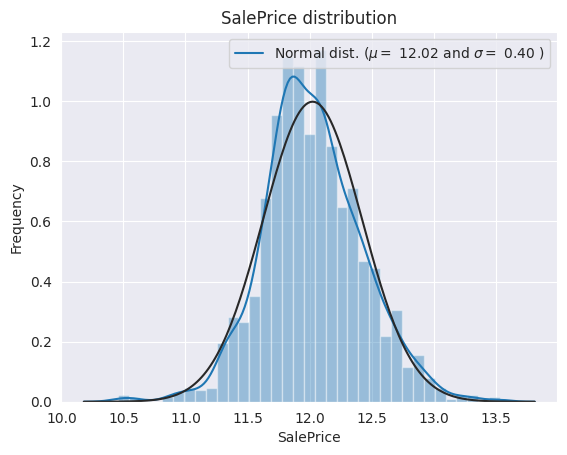

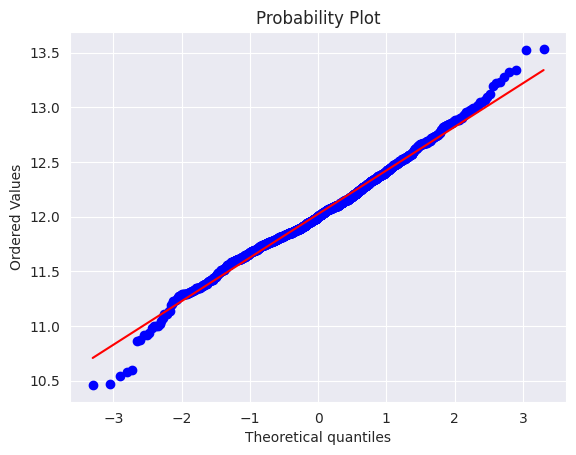

In [7]:
# ===============================================================================================================================
#                                             I.3. TARGET VARIABLE ANALYSIS ('SalePrice')
#                                                  Log-Transformation of 'SalePrice'
# ===============================================================================================================================

# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

# Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

**Note:**

The 'SalePrice' variable is now normally distributed. The skewness has been corrected. 

In [8]:
# ===============================================================================================================================
#                                                     I.4. FEATURES ENGINEERING
#                                                           Concatenation
# ===============================================================================================================================

# Concatenate train and test data in the same dataframe
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


Text(0.5, 1.0, 'Percent missing data by feature')

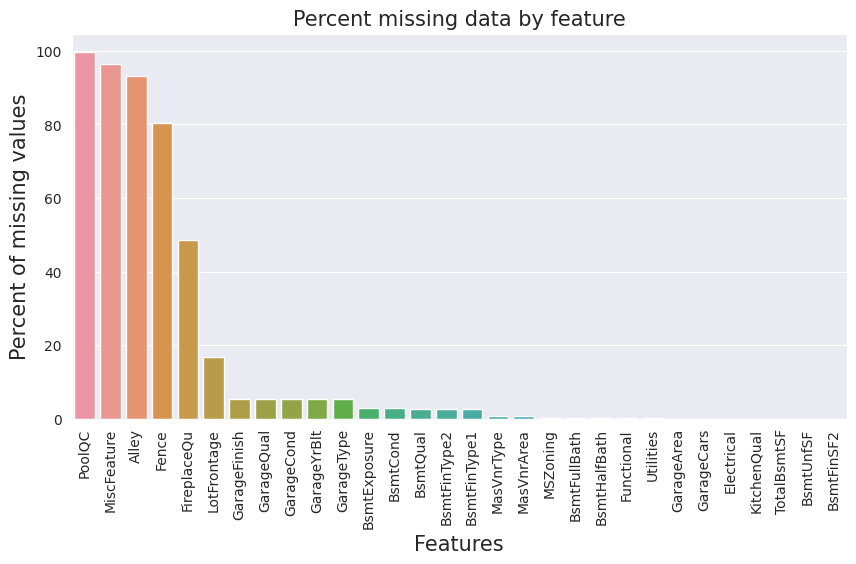

In [9]:
# ===============================================================================================================================
#                                                     I.5. FEATURES ENGINEERING
#                                                          Missing Data
# ===============================================================================================================================

# Compute the Missing Ratio for all features, then plot it
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})

f, ax = plt.subplots(figsize=(10, 5))
plt.xticks(rotation=90)
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [10]:
# ===============================================================================================================================
#                                                     I.6. FEATURES ENGINEERING
#                                                  Imputation of the Missing Data
# ===============================================================================================================================

# 'PoolQc' : NA means "No Pool"
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
# 'MiscFeature' : NA means "no misc feature"
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
# 'Alley' : NA means "no alley access"
all_data["Alley"] = all_data["Alley"].fillna("None")
# 'Fence' : NA means "no fence"
all_data["Fence"] = all_data["Fence"].fillna("None")
# 'FirePlaceQu' : NA means "no fireplace"
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

# 'LotFrontage' : We can fill in missing values by the median 'LotFrotnage' of the neighborhood. 
# Indeed, since the area of each street connected to the house property most likely have a similar area 
# to other houses in its neighborhood 
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

# 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond' : Replacing missing data with None
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
    
# 'GarageYrBlt', 'GarageArea' and 'GarageCars' : Replacing missing value with 0 (Since no garage = no cars in such garage)
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
    
# 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath' and 'BsmtHalfBath' : 
# missing values are likely zero for having no basement
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
    
# 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1' and 'BsmtFinType2' : 
# For all these categorical basement-related features, NaN means that there is no basement.
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
    
# 'MasVnrArea' and 'MasVnrType' : NA most likely means no masonry veneer for these houses. 
# We can fill 0 for the area and None for the type.
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

# 'MSZoning' (The general zoning classification) : 'RL' is by far the most common value. 
# So we can fill in missing values with 'RL'
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

# 'Utilities' : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . 
# Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. 
# We can then safely remove it.
all_data = all_data.drop(['Utilities'], axis=1)

# 'Functional' : data description says NA means typical
all_data["Functional"] = all_data["Functional"].fillna("Typ")

# 'Electrical' : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

# 'KitchenQual': Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) 
# for the missing value in KitchenQual.
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

# 'Exterior1st' and 'Exterior2nd' : Again Both Exterior 1 & 2 have only one missing value. 
# We will just substitute in the most common string
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

# 'SaleType' : Fill in again with most frequent which is "WD"
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

# 'MSSubClass' : Na most likely means No building class. We can replace missing values with None
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [11]:
# ===============================================================================================================================
#                                                      I.7. FEATURES ENGINEERING
#                                                    Check remaning missing value
# ===============================================================================================================================

# Check remaining missing values
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [12]:
# ===============================================================================================================================
#                                                     I.8. FEATURES ENGINEERING
#                                          Transforming numerical varibles which are categorical
# ===============================================================================================================================

# 'MSSubClass' : The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

# Changing 'OverallCond' into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

# Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [13]:
# ===============================================================================================================================
#                                                   I.9. FEATURES ENGINEERING
#                      Label Encoding some categorical variables that may contain information in their ordering set
# ===============================================================================================================================

from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


In [14]:
# ===============================================================================================================================
#                                                    I.10. FEATURES ENGINEERING
#                                     Adding the Total Area of Basement to dermine the house price
# ===============================================================================================================================

# Since area related features are very important to determine house prices, we add one more feature which is the 
# total area of basement, first and second floor areas of each house. 

# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [15]:
# ===============================================================================================================================
#                                                    I.11. FEATURES ENGINEERING
#                                                     Checking Skewed Features
# ===============================================================================================================================
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(5)


Skew in numerical features: 



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372


In [16]:
# ===============================================================================================================================
#                                                      I.12. FEATURES ENGINEERING
#                                          Box Cox Transformation of the highly skewed features
# ===============================================================================================================================

# We use the scipy function boxcox1p which computes the Box-Cox transformation of  1+x
# Note that setting  λ=0 is equivalent to log1p used above for the target variable.
# Ressources : 
    # https://onlinestatbook.com/2/transformations/box-cox.html
    # https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.special.boxcox1p.html

# BOX COX TRANSFORMATION
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
# CHECK IF IT WORKED
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(5)

There are 59 skewed numerical features to Box Cox transform

Skew in numerical features: 



,Skew
PoolArea,15.760
3SsnPorch,8.922
LowQualFinSF,8.741
MiscVal,5.595
LandSlope,4.530


In [17]:
# ===============================================================================================================================
#                                                    I.13. FEATURES ENGINEERING
#                                                Getting Dummy Categorical Features
# ===============================================================================================================================

all_data = pd.get_dummies(all_data)
print(all_data.shape)

# Getting the new train and test sets.
train = all_data[:ntrain]
test = all_data[ntrain:]

(2917, 220)


# II. Modelling

In [18]:
# ===============================================================================================================================
#                                                 II.1. IMPORT LIBRARIES
# ===============================================================================================================================
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [19]:
# ===============================================================================================================================
#                                           II.2. DEFINE A CROSS VALIDATION STRATEGY
# ===============================================================================================================================
# We use the cross_val_score function of Sklearn. However this function has not a shuffle attribut, 
# we add then one line of code, in order to shuffle the dataset prior to cross-validation

#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [20]:
# ===============================================================================================================================
#                                                     II.3. BASE MODELS
#                                                      LASSO Regression
# ===============================================================================================================================
# This model may be very sensitive to outliers. So we need to made it more robust on them. 
# For that we use the sklearn's Robustscaler() method on pipeline
lasso = make_pipeline(RobustScaler(), Lasso(alpha = 0.0009, random_state=1))

# ===============================================================================================================================
#                                                     II.3. BASE MODELS
#                                                   Elastic Net Regression
# ===============================================================================================================================
# Same, made more robust. 
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.008900000000000002, l1_ratio= 0.020089999999999972, random_state=3))

# ===============================================================================================================================
#                                                     II.3. BASE MODELS
#                                                  Kernel Ridge Regression
# ===============================================================================================================================
KRR = KernelRidge(alpha=0.0889, kernel='polynomial', degree=2, coef0=2.5)

# ===============================================================================================================================
#                                                     II.3. BASE MODELS
#                                               Gradient Boosting Regression
# ===============================================================================================================================
# Using 'huber' loss to make it robust to outliers
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

# ===============================================================================================================================
#                                                     II.3. BASE MODELS
#                                                    XGBoost Regression
# ===============================================================================================================================
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
GradientBoostingRegressor XGBoost LightGBM

# ===============================================================================================================================
#                                                     II.3. BASE MODELS
#                                                    LightGBM Regression
# ===============================================================================================================================
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

SyntaxError: invalid syntax (2402778645.py, line 42)

In [ ]:
# ===============================================================================================================================
#                                                  II.3. BASE MODELS SCORES
# ===============================================================================================================================
# Check the base models performance on the data by evaluating the cross-validation 'rmsle error'. 

score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

In [ ]:
# ===============================================================================================================================
#                                                  II.4. STACKING MODELS
# ===============================================================================================================================
# Let's create a new class to extend scikit-learn with our model and also to laverage encapsulation and code reuse (inheritance)

class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [ ]:
# ===============================================================================================================================
#                                                  II.4. STACKING MODELS
#                                               Averaged Base Models Score
# ===============================================================================================================================
averaged_models = AveragingModels(models = (lasso, ENet, KRR, GBoost, model_xgb, model_lgb))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))



# III. PREDICTION

In [ ]:
# ===============================================================================================================================
#                                            III.1. TRAINING, then PREDICTION
# ===============================================================================================================================
averaged_models.fit(train.values, y_train)
train_pred = averaged_models.predict(train.values)
pred = np.expm1(averaged_models.predict(test.values))


In [ ]:
# ===============================================================================================================================
#                                            III.2. SUBMISSION
# ===============================================================================================================================
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = pred
sub.to_csv('submission_stacked_Regression.csv',index=False)